TODO LONG-TERM
* Complete function documentation.
* Jail strategy is hard-coded as, in order, use a Get-Out-Of-Jail card, pay the fine, and roll the dice. In the future, strategy selection should be able to vary across players and be context-sensitive.

# Rules of the game

From: https://en.wikibooks.org/wiki/Monopoly/Official_Rules
And: https://www.hasbro.com/common/instruct/00009.pdf

## General
* On a player's turn, the player must roll the dice and move his/her token forward the number of spaces as rolled on the dice. [Implemented!]
* If the player lands on an unowned property, the player may buy it for the price listed on that property's space.
 * If he or she agrees to buy it, he or she pays the Bank the amount shown on the property space and receives the deed for that property. [Implemented!]
 * If he or she refuses to buy the property for the amount stated on the deed, the property is auctioned. Bidding may start at any price, and all players may bid. The highest bidder wins the property and pays the Bank the amount bid and receives the property's title deed. [**Not implemented**]
  * Railroads and utilities are also considered properties. [Implemented!]
* If the player lands on an unmortgaged property owned by another player, he or she pays rent to that person, as specified on the property's deed. It is the property owner's responsibility to demand rent, and he or she has until the beginning of the second following player's turn to do so. [Implemented!]
* If the player lands on his or her own property, or on property which is owned by another player but currently mortgaged, nothing happens. [Implemented!]
* If the player lands on Luxury Tax/Super Tax, he or she must pay the Bank \$100 [Implemented!]
* If the player lands on Income Tax he or she must pay the Bank either \$200 or 10% of his or her total assets (cash on hand, property, houses and hotels). [Implemented!]
* If the player lands on a Chance or Community Chest, the player takes a card from the top of the respective pack and performs the instruction given on the card. [**Not implemented**]
* If the player lands on the Jail space, he or she is "Just Visiting". No penalty applies. [Implemented!]
* If the player lands on the Go to Jail square, he or she must move his token directly to Jail. [Implemented!]
* If the player lands on or passes Go in the course of his or her turn, he or she receives \$200 from the Bank. A player has until the beginning of his or her next turn to collect this money.[Implemented!]
* You may sell houses back to the Bank for half the purchase price or sell property deeds to other players in the game. [**Not implemented**]
* Players may not loan money to other players. Only the Bank can loan money, and then only by mortgaging properties. [Implemented!]
* If a player skips another player's turn and is caught, the turn is transferred back to the player whose turn was skipped. [Implemented!]

## Doubles
* When doubles are rolled, the player resolves the roll as normal (including purchase, renting or passing "GO"), but rolls the dice again for another turn. [Implemented!]
 * The player moves forward as directed by the dice, and if this is also doubles, rolls again. [Implemented!]
 * If the third dice roll is doubles, the player is instead moved directly to jail. [Implemented!]
* The sole exception is rolling doubles to exit jail, which doesn't allow for an additional turn.[**Need to confirm this**]

## Jail
* A player is moved to jail when:
 * landing on the square marked "Go to Jail" [Implemented!]
 * drawing a card marked "Go to Jail" [**Not implemented**]
 * rolling three consecutive doubles when moving in a turn. [**Not implemented**]
* Rules:
 * The player is placed directly in the jail cell, and does not get any benefit for passing "GO". [Implemented!]
 * A player that lands normally in the Jail square is in the "Just Visiting" section, and is unhindered. [Implemented!]
 * If a player is in jail that player may not continue to collect rent from any property. [**Not implemented**]
* When in jail, a player may:
 * use a get out of jail free card (either owned, or purchased from another player) [**???**]
 * pay the \$50 fine [**???**]
 * Otherwise, the player can attempt to escape jail by trying to roll doubles: [**???**]
  * if successful, the player moves the number of squares but doesn't get the extra turn
  * If the player fails to roll doubles for three turns, he or she must pay the \$50 fine and then moves the number shown on the dice.

## Properties, Rents, and Construction

### General property rules
* If a player lands on property he may:
 * buy it at the listed price [Implemented!]
 * If the player refuses to buy it, then the Bank sells it at auction to the highest bidder. All players, including the one who chose to not buy it, may bid on the property. [**Not implemented**]
* Properties are arranged in "color groups" of two or three properties. [Implemented!]
* Once a player owns all properties of a color group (a monopoly), the rent is now doubled on all unimproved lots of that color group, even if any of the properties are mortgaged to the Bank. [Implemented!]
* The player may purchase up to four houses or one hotel per property (and only if there are properties to hold the houses), which raise the rents that must be paid when other players and on the property. [Implemented so, that all properties of the color must be owned!]
* The properties in a color group must be developed evenly, i.e. each house that is built must go on a property in the group with the fewest number of houses on it so far. [Implemented!]
* A hotel may be built on a color group only after all properties in the group have four houses. A player purchases a hotel by paying the price of an additional house, and returning the four houses on that property to the Bank in exchange for a hotel. [Implemented!]
* If a property is owned by a player and another player lands on the property and the owner does not realize it before the second following player rolls the dice then the player does not have to pay the owner. [Implemented!]
* At any time a player may, to raise cash, sell hotels and houses back to the Bank for half of the purchase price of the houses. [**Not implemented**]
* Also, properties with no houses or hotels may be mortgaged for half of the property price. [**Not implemented**]
 * A property does not collect rent while mortgaged and may not be developed. [**Not implemented**]
 * To de-mortgage a property a player must pay interest of 10% in addition to the mortgage price. [**Not implemented**]
 * Whenever a mortgaged property changes hands between players, either through a trade, sale or by bankruptcy, the new owner must immediately pay 10% interest on the mortgage and at their option may pay the principal or hold the property. [**Not implemented**]
 * If the player holds the property and later wishes to lift the mortgage they must pay the 10% interest again as well [**Not implemented**]
* If a player wishes to buy a house/hotel for a property, it is not necessary to wait for their turn. The player can buy houses/hotels even if it is not their turn. The player does not need to be on the property they wish to put the house/hotel on. [**Not fully implemented**]

### Railroad
* The rent a player charges for landing on a railroad varies with the number of railroads that are also owned by a player. [Implemented!]
 * The rent is as follows:
  * Charge \$25 if one is owned,
  * \$50 if two are owned,
  * \$100 if three are owned,
  * \$200 if all four are owned.

### Utility Rent
* For utilities, after a player lands on one to owe rent, the rent is: [Implemented!]
 * 4 times the amount rolled, if the player owns one utility.
 * If the player possesses both utilities, the rent is 10 times the amount rolled.

### Import modules

In [11]:
# To be removed later
import time

# General
import numpy as np
import pandas as pd
import random
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

### Make declarations

In [10]:
VERBOSE = False
VERBOSE = True

### Define functions

In [33]:
def get_players(game_logics, board):

    n_players = len(game_logics)
    assert n_players > 2, 'A game must have at least 2 players.'
    assert n_players < 8, 'A game must have no more than 8 players.'

    class Player(object):

        def __init__(self, player_id, game_logic, board):
            self.id = player_id  # Identification number
            self.cash = 1500     # Cash on hand
            self.owned_properties = [] # List of owned properties' positions
            self.position = 0    # Board position
            self.jail_cards = 0  # Number of "Get Out Of Jail Free" cards
            self.jail_turns = 0  # Number of remaining turns in jail
            self.jail_strtg = '' # Jail strategy
            self.game_strategy = get_player_logic(self, board, game_logic)
            self.bankrupt = False
            self.bankrupt_game_round = None

        def move(self, roll, board):
            self.position += roll
            passed_go = False
            if self.position >= 40:
                self.position -= 40
                self.cash += 200
                passed_go = True
            if VERBOSE:
                if passed_go:
                    print('Player %d from position %d to %d passing go (Cash now: %d)' %
                          (self.id, self.position - roll, self.position, self.cash))
                else:
                    print('Player %d from position %d to %d' %
                          (self.id, self.position - roll, self.position))

            # Define current board space
            curr_space = board[self.position]

            # Landed on somebody else's property?
            prop_type = type(curr_space).__name__
            if prop_type == 'Street' or prop_type == 'Railroad' or prop_type == 'Utility':
                prop_has_owner = curr_space.owner is not None
                prop_is_mine = prop_has_owner and curr_space.owner == self.id
                if (prop_has_owner and
                    prop_is_mine == False and
                    players[curr_space.owner].jail_turns == 0 and
                    players[curr_space.owner].bankrupt == False):
                    # Pay the rent, to a player who is not in jail, and not in bankrupt
                    self.bankrupt = self.pay(players[curr_space.owner], curr_space, board, roll)
            elif prop_type == 'Tax':
                self.bankrupt = self.pay_tax(curr_space, board)

            return curr_space

        def evaluate_buy(self, prop):
            prop_has_owner = prop.owner is not None
            prop_is_mine = prop_has_owner and prop.owner == self.id

            # Build?
            self.game_strategy.build_before_buying()

            # Landed on my property?
            if prop_has_owner and prop_is_mine == True:
                # No-op, no need to pay to self
                pass
            elif not prop_has_owner:
                # Landed on unowned property
                self.game_strategy.buy(prop)

            # Build?
            self.game_strategy.build_after_buying()

        def buy(self, prop, board):
            self.owned_properties.append(prop.position)
            self.cash -= prop.price
            prop.owner = self.id
            properties_in_group = self._update_rent(prop, board)

            if VERBOSE:
                prop_type = type(prop).__name__
                if prop_type == 'Street':
                    print('Player %d bought %s owning %d/%d %s properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.color, prop.price, self.cash))
                elif prop_type == 'Railroad':
                    print('Player %d bought Railroad %s owning %d/%d properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.price, self.cash))
                elif prop_type == 'Utility':
                    print('Player %d bought Utility %s owning %d/%d properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.price, self.cash))

        def sell(self, prop, board):
            for idx, position in enumerate(self.owned_properties):
                if position == prop.position:
                    del(self.owned_properties[idx])
                    break
            self.cash += prop.price_mortgage
            prop.owner = None
            prop_type = type(prop).__name__
            if prop_type == 'Street':
                if prop.building_cnt > 0:
                    self.cash += prop.price_building / 2
                    prop.building_cnt = 0

            board.property_update(prop)
            properties_in_group = self._update_rent(prop, board)

            if VERBOSE:
                if prop_type == 'Street':
                    print('Player %d sold %s owning %d/%d %s properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.color, prop.price, self.cash))
                elif prop_type == 'Railroad':
                    print('Player %d sold Railroad %s owning %d/%d properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.price, self.cash))
                elif prop_type == 'Utility':
                    print('Player %d sold Utility %s owning %d/%d properties (Price: %d, Cash now: %d)' %
                          (self.id, prop.name, len(properties_in_group), prop.size_monopoly, prop.price, self.cash))

        def _update_rent(self, prop, board):
            properties_in_group = []
            prop_type = type(prop).__name__
            for prop_pos in self.owned_properties:
                a_prop = board.get_proprty_by_pos(prop_pos)

                # We can compare only properties of same type
                if type(a_prop).__name__ != prop_type:
                    continue

                # A property of correct type was found
                if prop_type == 'Street':
                    if a_prop.color == prop.color:
                        properties_in_group.append(a_prop)
                elif prop_type == 'Railroad':
                    properties_in_group.append(a_prop)
                elif prop_type == 'Utility':
                    properties_in_group.append(a_prop)

            # Railroad has special rule for rent
            if prop_type == 'Railroad':
                for a_prop in properties_in_group:
                    a_prop.rent_now = len(properties_in_group) * a_prop.rent

            # Got monopoly?
            if prop_type == 'Street' and len(properties_in_group) == prop.size_monopoly:
                # Yesh! Got monopoly for this color.
                # Raise the rents!
                for a_prop in properties_in_group:
                    a_prop.rent_now = a_prop.rent_monopoly

            return properties_in_group
    
        def build(self, prop):
            if prop.building_cnt == 5:
                return

            self.cash -= prop.price_building
            prop.rent_now = prop.rent_building[prop.building_cnt]
            prop.building_cnt += 1
            if VERBOSE:
                print('Player %d built a house %s of %s color, has %d houses (Price: %d, Cash now: %d)' %
                      (self.id, prop.name, prop.color, prop.building_cnt, prop.price, self.cash)
                     )

        def sell_building(self, prop, buildings_to_sell):
            if buildings_to_sell > prop.building_cnt:
                raise RuntimeError("Internal: Selling building failed! Property %s at position %d has %d buildings, requested to sell %d" %
                                   (prop.name, prop.position, prop.building_cnt, buildings_to_sell))

            self.cash += (prop.price_building / 2) * buildings_to_sell
            prop.building_cnt -= buildings_to_sell
            if prop.building_cnt > 0:
                prop.rent_now = prop.rent_building[prop.building_cnt - 1]
            else:
                prop.rent_now = prop.rent
            if VERBOSE:
                print('Player %d sold %d houses %s of %s color, has %d houses (Price: %d, Cash now: %d)' %
                      (self.id, buildings_to_sell, prop.name, prop.color, prop.building_cnt, prop.price, self.cash)
                     )

        def pay(self, other, prop, board, dice_roll):
            # Utility has special rule for rent
            prop_type = type(prop).__name__
            if prop_type == 'Utility':
                properties_in_group = []
                for prop_pos in other.owned_properties:
                    a_prop = board.get_proprty_by_pos(prop_pos)
                    # We can compare only properties of same type
                    if type(a_prop).__name__ != prop_type:
                        continue

                    properties_in_group.append(a_prop)
                if len(properties_in_group) == 1:
                    payment = 4 * dice_roll
                elif len(properties_in_group) == 2:
                    payment = 10 * dice_roll
                else:
                    # Should never reach this
                    payment = 0
            elif prop_type == 'Street' or prop_type == 'Railroad':
                # Streets and railroads have fixed price
                payment = prop.rent_now
            else:
                return

            if payment > self.cash:
                if VERBOSE:
                    print('Player %d cannot pay $%d to Player %d (Payment: %d, Cash now: %d)' %
                          (self.id, payment, other.id, payment, self.cash)
                         )
                if self.run_out_of_cash(payment, board):
                    return True
            self.cash -= payment
            other.cash += payment
            if VERBOSE:
                print('Player %d paid $%d (%s) to Player %d (Cash now: %d)' %
                      (self.id, payment, prop.name, other.id, self.cash)
                     )
            return False

        def pay_tax(self, prop, board):
            tax_type = prop.name
            if tax_type == 'Luxury Tax':
                payment = prop.tax
            else:
                # Income tax is $200 or 10% of all cash and assets player has
                payment = int(self.value(board, True) / 10)
                if payment > prop.tax:
                    payment = prop.tax
            if payment > self.cash:
                if VERBOSE:
                    print('Player %d cannot pay $%d %s (Cash now: %d)' %
                          (self.id, payment, prop.name, self.cash)
                         )
                if self.run_out_of_cash(payment, board):
                    return True

            # Pay the taxes
            self.cash -= payment

            return False

        def go_to_jail(self):
            self.position = 10
            self.jail_turns = 3
            if VERBOSE:
                print('Player %d goes to jail' % (self.id))

        def choose_jail_strtg(self, rolled_double, board):
            if self.jail_cards > 0:
                self.jail_strtg = 'card'
                self.jail_turns = 0
                self.jail_cards -= 1
            elif self.cash >= 50:
                self.jail_strtg = 'pay'
                self.jail_turns = 0
                self.cash -= 50
            else:
                self.jail_strtg = 'roll'
                if rolled_double:
                    self.jail_turns = 0
                else:
                    self.jail_turns -= 1
                    if self.jail_turns == 0:
                        if self.cash >= 50:
                            self.cash -= 50
                        else:
                            if VERBOSE:
                                print('Player %d cannot pay jail fee of $50 (Cash now: %d)' %
                                      (self.id, self.cash)
                                     )
                            if self.run_out_of_cash(50, board):
                                self.bankrupt = True
                            else:
                                self.cash -= 50
            if VERBOSE:
                print('Player %d took jail strategy %s and has %d jail turns left' %
                      (self.id, self.jail_strtg, self.jail_turns)
                     )

        def run_out_of_cash(self, payment, board):
            assets = self.value(board, False)
            if VERBOSE:
                print("Player %d ran out of cash. Cannot pay $%d, has $%d in cash, $%d total assets" %
                      (self.id, payment, self.cash, assets))
            if payment > assets:
                if VERBOSE:
                    print("Cannot pay $%d, Total value of Player %d's assets is $%d. Defaulting." % (payment, self.id, assets))
                # No matter what player would do, there is not enough funds.
                return True

            # Need to sell something
            self.game_strategy.sell_properties(payment)

            # Sanity check for internal logic
            if self.cash < payment:
                raise RuntimeError("Internal: Selling failed! Need cash for $%d payment, has only $%d" % (payment, self.cash))

            return False

        def default(self, board):
            # Release all player's properties back to market.
            # ToDo:
            # - if debt is to another player:
            #   - sell all the buildings to raise cash
            #   - all your cash goes to that player
            #   - all your properties goes to that player
            # - if debt is to bank:
            #   - everything of value goes to bank
            #   - bank will auction the properties to remaining players (no buildings)
            if not self.bankrupt:
                raise RuntimeError("Internal: Attempt to default a non-bankrupt player %d!" % self.id)

            while self.owned_properties:
                prop_pos = self.owned_properties.pop()
                prop = board.get_proprty_by_pos(prop_pos)
                prop.owner = None
                prop_type = type(prop).__name__
                if prop_type == 'Street':
                    if prop.building_cnt > 0:
                        prop.building_cnt = 0

                properties_in_group = self._update_rent(prop, board)
                board.property_update(prop)

        def value(self, board, full_value, verbose=False):
            # Full value of assets is needed for Taxes.
            # Properties and buildings amount to half value, if need to sell them.
            total_value = self.cash
            
            for prop_pos in self.owned_properties:
                a_prop = board.get_proprty_by_pos(prop_pos)
                prop_type = type(a_prop).__name__
                if prop_type == 'Street':
                    if full_value:
                        if verbose:
                            print("%d: asset %s (%s) at %d, full value $%d, buildings %d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price, a_prop.building_cnt))
                        total_value += a_prop.price
                        if a_prop.building_cnt > 0:
                            total_value += a_prop.price_building * a_prop.building_cnt
                    else:
                        if verbose:
                            print("%d: asset %s (%s) at %d, sell value $%d, buildings %d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price / 2, a_prop.building_cnt))
                        total_value += a_prop.price / 2
                        if a_prop.building_cnt > 0:
                            total_value += (a_prop.price_building / 2) * a_prop.building_cnt
                elif prop_type == 'Railroad':
                    if full_value:
                        if verbose:
                            print("%d: asset %s (%s) at %d, full value $%d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price))
                        total_value += a_prop.price
                    else:
                        if verbose:
                            print("%d: asset %s (%s) at %d, sell value $%d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price / 2))
                        total_value += a_prop.price / 2
                elif prop_type == 'Utility':
                    if full_value:
                        if verbose:
                            print("%d: asset %s (%s) at %d, full value $%d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price))
                        total_value += a_prop.price
                    else:
                        if verbose:
                            print("%d: asset %s (%s) at %d, sell value $%d" % (self.id, prop_type, a_prop.name, a_prop.position, a_prop.price / 2))
                        total_value += a_prop.price / 2

            return total_value

    return [Player(p, logic, board) for p, logic in enumerate(game_logics)]

In [22]:
PLAYER_LOGIC_GREEDY = 1
PLAYER_LOGIC_GREEDY_HAMSTER = 2

def get_player_logic(user, board, logic_mode):

    class PlayerLogic(object):
        def __init__(self, user, board):
            self.user = user
            self.board = board

        def _get_property_groups(self, types):
            # Create a list of properties grouped by the color
            groups = {}
            for prop_pos in self.user.owned_properties:
                a_prop = self.board.get_proprty_by_pos(prop_pos)
                prop_type = type(a_prop).__name__
                if prop_type not in types:
                    continue
                if prop_type == 'Street':
                    if a_prop.color not in groups.keys():
                        groups[a_prop.color] = []
                    groups[a_prop.color].append(a_prop)
                elif prop_type in ['Railroad', 'Utility']:
                    if prop_type not in groups.keys():
                        groups[prop_type] = []
                    groups[prop_type].append(a_prop)
                else:
                    raise RuntimeError("Internal: Don't know what to do with property %s" % prop_type)

            return groups

        def can_build_to_color(self, color_requested):
            groups = self._get_property_groups(['Street'])
            for color, group in groups.items():
                if color != color_requested:
                    continue

                properties_owned = len(group)
                properties_in_group = group[0].size_monopoly
                if properties_owned < properties_in_group:
                    # Nope, doesn't own all properties of this color
                    break

                # All properties of given color are owned
                # Arrange the properties in given color group to a list
                # containing the number of houses on each property.
                house_cnts = {}
                for idx, prop in enumerate(group):
                    house_cnts[idx] = prop.building_cnt
                # Sort the list by house count, ascending
                house_cnts = [(k, house_cnts[k]) for k in sorted(house_cnts, key=house_cnts.get)]
                # From the sorted property list, pick the first one as the one to build on.
                prop_to_buy = house_cnts[0][0]
                prop_to_buy = group[prop_to_buy]

                # Return the propery having least houses in it
                return prop_to_buy

            return None

        def sell_properties(self, payment):
            # A payment is due, but has not enough cash.
            # Let's find a property to liquidate.
            need_cash = payment - self.user.cash
            if VERBOSE:
                print("Selling properties to fullfill a payment of $%d, need cash: $%d" % (payment, need_cash))
            if need_cash < 0:
                # Weird, we have the cash for the payment.
                self.user.cash -= payment
                return
                
            groups = self._get_property_groups(['Street', 'Railroad', 'Utility'])

            # 1) Try finding a property without buildings.
            #    Must be the single property of that group.
            candidates = {}
            for color, group in groups.items():
                if len(group) == 1 and group[0].price_mortgage >= need_cash:
                    candidates[group[0].position] = group[0].price_mortgage
            if len(candidates) > 0:
                # Order the suitable properties by value and sell the cheapest
                candidates = sorted(candidates.items())
                prop_to_sell = self.board.get_proprty_by_pos(candidates[0][0])
                if VERBOSE:
                    print("Selling single property to solve the financial problem.")
                self.user.sell(prop_to_sell, self.board)
                # Problem solved! Continue gaming
                return
            if VERBOSE:
                print("Didn't find a single property to sell to raise enough cash.")

            # 2) Sell the cheapest ones?
            #    Must be the single property of that group.
            candidates = {}
            for color, group in groups.items():
                if len(group) == 1:
                    candidates[group[0].position] = group[0].price_mortgage
            if len(candidates) > 0:
                candidates = sorted(candidates.items())
                total_value = 0
                props_to_sell = []
                for idx, mortgage_value in candidates:
                    prop_to_sell = self.board.get_proprty_by_pos(idx)
                    props_to_sell.append(prop_to_sell)
                    total_value += mortgage_value
                    if total_value >= need_cash:
                        if VERBOSE:
                            print("Selling %d properties from groups having only single to solve the financial problem." % len(props_to_sell))
                        for prop_to_sell in props_to_sell:
                            self.user.sell(prop_to_sell, self.board)
                        # Problem solved! Continue gaming
                        return
            if VERBOSE:
                print("Didn't find set of single properties to sell to raise enough cash.")

            # 3) Try finding any property without buildings where there is no monopoly.
            #    Idea is to sell as many owned properties without monopoly to raise cash.
            #    Utilities and railroads are sold here regardless of monopoly.
            candidates = {}
            for color, group in groups.items():
                if len(group) < group[0].size_monopoly or color in ['Railroad', 'Utility']:
                    for prop_to_sell in group:
                        candidates[prop_to_sell.position] = prop_to_sell.price_mortgage
            total_value = 0
            props_to_sell = []
            if len(candidates) > 0:
                candidates = sorted(candidates.items())
                for idx, mortgage_value in candidates:
                    prop_to_sell = self.board.get_proprty_by_pos(idx)
                    props_to_sell.append(prop_to_sell)
                    total_value += mortgage_value
                    if total_value >= need_cash:
                        if VERBOSE:
                            print("Selling %d properties to solve the financial problem." % len(props_to_sell))
                        for prop_to_sell in props_to_sell:
                            self.user.sell(prop_to_sell, self.board)
                        # Problem solved! Continue gaming
                        return
            if VERBOSE:
                print("Didn't find enough properties without monopoly to sell. Would get $%d out of them." % total_value)

            # 4) On top of 3), sell buildings, don't break monopolies.
            #    The properties are ordered 
            groups = self._get_property_groups(['Street'])
            candidates = {}
            for color, group in groups.items():
                if len(group) == group[0].size_monopoly:
                    candidates[color] = 0
                    for prop in group:
                        candidates[color] += prop.building_cnt
            total_value_of_buildings = 0
            need_cash_from_buildings = need_cash - total_value
            if VERBOSE:
                print("On top of $%d from properties, still need $%d from buildings" % (total_value, need_cash_from_buildings))
            if len(candidates) > 0:
                # Logic is: Properties with more buildings produce more revenue.
                # Sort candidates by building count, sell buildings on properties
                # having least amount of buildings in them regardless of the value.
                # The building selling rule is, that they need to be sold evenly from
                # all properties. That is the reverse of buyin buildings evenly.
                candidates = sorted(candidates.items())
                buildings_to_sell = []
                for group_to_sell, building_cnt in candidates:                
                    if building_cnt == 0:
                        # No buildings at all in this group
                        continue
                    for color, group in groups.items():
                        if group_to_sell != color:
                            continue

                        # Gather list of building amounts. Cannot sell more than there are buildings.
                        buildings_in_properties = {}
                        for prop_to_sell in group:
                            buildings_in_properties[prop_to_sell.position] = prop_to_sell.building_cnt

                        # Iterate the chosen group and sell buildings one by one.
                        # Stop if there are no more buildings in this group to sell, or
                        # enough money has been made available.
                        while total_value_of_buildings < need_cash_from_buildings and buildings_in_properties:
                            # Sort the list by house count, ascending
                            house_cnts = [(k, buildings_in_properties[k]) for k in sorted(buildings_in_properties, key=buildings_in_properties.get, reverse=True)]
                            # From the sorted property list, pick the first one as the one to build on.
                            prop_to_sell = house_cnts[0][0]
                            prop_to_sell = self.board.get_proprty_by_pos(prop_to_sell)
                            building_value = prop_to_sell.price_building / 2
                            buildings_to_sell.append(prop_to_sell)
                            buildings_in_properties[prop_to_sell.position] -= 1
                            if buildings_in_properties[prop_to_sell.position] == 0:
                                # Remove property from list when all buildings are sold
                                buildings_in_properties.pop(prop_to_sell.position, None)
                            total_value_of_buildings += building_value

                    # Stop iterating groups if there is enough buildings sold
                    if total_value_of_buildings > need_cash_from_buildings:
                        break

                # If the selling will solve the problem, go for it!
                if total_value_of_buildings > need_cash_from_buildings:
                    if VERBOSE:
                        print("Selling %d buildings and %d properties to solve the financial problem." %
                              (len(buildings_to_sell), len(props_to_sell)))
                    # Buildings
                    for prop_to_sell in buildings_to_sell:
                        self.user.sell_building(prop_to_sell, 1)

                    # Properties
                    for prop_to_sell in props_to_sell:
                        self.user.sell(prop_to_sell, self.board)

                    # Problem solved! Continue gaming
                    return
                else:
                    if VERBOSE:
                        print("Total value of all buildings is $%d. Selling all properties next." % total_value_of_buildings)
            else:
                if VERBOSE:
                    print("Doesn't have any buildings to sell.")

            # 5) On top of 3) and 4), sell properties with monopoly.
            candidates = {}
            for color, group in groups.items():
                if len(group) == group[0].size_monopoly:
                    for prop in group:
                        candidates[prop.position] = prop.price_mortgage
            if len(candidates) > 0:
                candidates = sorted(candidates.items())
                print(candidates)
                for idx, mortgage_value in candidates:
                    prop_to_sell = self.board.get_proprty_by_pos(idx)
                    props_to_sell.append(prop_to_sell)
                    total_value += mortgage_value
                    if total_value + total_value_of_buildings >= need_cash:
                        if VERBOSE:
                            print("Selling %d buildings and %d properties to solve the financial problem. Selling also monopolies." %
                                  (len(buildings_to_sell), len(props_to_sell)))
                        # Buildings
                        for prop_to_sell in buildings_to_sell:
                            self.user.sell_building(prop_to_sell, 1)

                        # Properties
                        for prop_to_sell in props_to_sell:
                            self.user.sell(prop_to_sell, self.board)

                        # Problem solved! Continue gaming
                        return
            else:
                if VERBOSE:
                    print("Didn't find enough properties with monopoly to sell. This is weird.")

            # Failure!
            # Selling everything didn't solve the problem. We should be here. Ever.
            self.user.value(board, False, True)
            raise RuntimeError("Internal: Failure do sell properties for player %d for payment!" % self.user.id)


    class PlayerLogicGreedy(PlayerLogic):

        def buy(self, prop):
            # Greedy, buy all!
            self_can_afford = self.user.cash >= prop.price
            if self_can_afford:
                self.user.buy(prop, self.board)

        def build_before_buying(self):
            # See if any properties are owned
            if not self.user.owned_properties:
                return

            # This logic buys buildings before buying property.

        def build_after_buying(self):
            # See if any properties are owned
            if not self.user.owned_properties:
                return

            # This logic buys buildings after buying property
            # Iterate the property groups to find the property in the group having least buildings.
            groups = self._get_property_groups(['Street'])
            for color, group in groups.items():
                prop_to_buy = self.can_build_to_color(color)
                while prop_to_buy:
                    self_can_afford = self.user.cash >= prop_to_buy.price_building
                    if self_can_afford and prop_to_buy.building_cnt < 5:
                        self.user.build(prop_to_buy)
                        prop_to_buy = self.can_build_to_color(color)
                    else:
                        break

            # done!

    class PlayerLogicGreedyHamster(PlayerLogicGreedy):

        def buy(self, prop):
            # This user is bit more careful.
            # The idea is to keep a minimum amount of cash available
            if self.user.cash <= 500:
                return

            # When has more than $500, consider byuing
            return super(PlayerLogicGreedyHamster, self).buy(prop)

        def build_after_buying(self):
            # This user is bit more careful.
            # The idea is to keep a minimum cash of $1000 at hand
            # and to be able to pay income tax.
            assets = self.user.value(self.board, True)
            if self.user.cash <= 1000 or self.user.cash < assets/10:
                return

            # When has more than $1000, consider building
            return super(PlayerLogicGreedyHamster, self).build_after_buying()

    if logic_mode == PLAYER_LOGIC_GREEDY:
        return PlayerLogicGreedy(user, board)
    if logic_mode == PLAYER_LOGIC_GREEDY_HAMSTER:
        return PlayerLogicGreedyHamster(user, board)

    raise RuntimeError('Internal: Logic %d not known!' % logic_mode)

In [14]:
def get_board(board_file):

    class Property(object):
        def __init__(self, name, position, price, rent):
            self.name = name
            self.position = position
            self.price = price
            self.price_mortgage = price / 2
            self.rent = rent
            self.rent_now = rent
            self.mortgage = False
            self.owner = None

    class Street(Property):
        def __init__(self, name, position, color, price, price_building, rent, rent_building, size_monopoly):
            Property.__init__(self, name, position, price, rent)
            self.color = color
            self.price_building = price_building
            self.rent_monopoly = rent * 2
            self.rent_building = rent_building
            self.size_monopoly = size_monopoly
            self.building_cnt = 0

    class Railroad(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_double = rent * 2
            self.rent_triple = self.rent_double * 2
            self.rent_monopoly = self.rent_triple * 2
            self.size_monopoly = 4
    
    class Utility(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_monopoly = rent + 6
            self.size_monopoly = 2
    
    class Tax(object):
        def __init__(self, name, price):
            self.name = name
            self.tax = price

    class Card(object):
        pass  
    
    class Chance(object):
        pass
    
    class Chest(object):
        pass
    
    class Jail(object):
        pass
    
    class Idle(object):
        pass

    class MonopolyBoard(object):
        def __init__(self):
            self.board = []
            self.board_by_pos = {}
            self.all_properties_have_owner = False
            self.properties_by_group = {}

        def append(self, prop):
            self.board.append(prop)
            if hasattr(prop, 'position'):
                self.board_by_pos[prop.position] = prop

            # Pass 1: Group streets by color
            self.properties_by_group = {}
            for prop in self.board:
                prop_type = type(prop).__name__
                if prop_type == 'Street':
                    if prop.color not in self.properties_by_group:
                        self.properties_by_group[prop.color] = []
                    self.properties_by_group[prop.color].append(prop)

            return self

        def property_update(self, prop):
            self.all_properties_have_owner = False

        def __getitem__(self, key):
            return self.board[key]

        def get_proprty_by_pos(self, pos):
            return self.board_by_pos[pos]

        def all_properties_are_owned(self):
            if self.all_properties_have_owner:
                return True

            for prop in self.board:
                prop_type = type(prop).__name__
                if prop_type == 'Street' or prop_type == 'Railroad' or prop_type == 'Utility':
                    if prop.owner is None:
                        return False

            # Game has reached a position where all properties are owned by player
            self.all_properties_have_owner = True

            return True

        def player_can_build(self):
            # See if building is possible (ignoring the fact that there may already be buildings)
            players_having_monopoly = {}
            for color in self.properties_by_group.keys():
                first_owner = None
                found_one = True
                for prop in self.properties_by_group[color]:
                    if prop.owner is None:
                        # Unowned property, no player can own all of the same color
                        found_one = False
                        break
                    if first_owner is None:
                        # There is an owner, get a compare subject
                        first_owner = prop.owner
                        continue
                    if prop.owner != first_owner:
                        # There is an owner, but it's different player than we expet
                        found_one = False
                        break
                if found_one:
                    # A full color is owned by a player
                    players_having_monopoly[first_owner] = True

            return list(players_having_monopoly.keys())

    board = MonopolyBoard()
    
    for _, r in pd.read_csv(board_file).iterrows():
        object_class = r['class']
        if object_class == 'Street':
            board.append(Street(r['name'], r['position'], r['monopoly'],
                                r['price'], r['build_cost'], r['rent'],
                                [r['rent_house_1'], r['rent_house_2'], r['rent_house_3'],
                                 r['rent_house_4'], r['rent_hotel']],
                                r['monopoly_size']))
        elif object_class == 'Railroad':
            board.append(Railroad(r['name'], r['position'], r['price'], r['rent']))
        elif object_class == 'Utility':
            board.append(Utility(r['name'], r['position'], r['price'], r['rent']))
        elif object_class == 'Tax':
            board.append(Tax(r['name'], r['tax']))
        elif object_class == 'Chance':
            board.append(Chance())
        elif object_class == 'Chest':
            board.append(Chest())
        elif object_class == 'Jail':
            board.append(Jail())
        elif object_class == 'Idle':
            board.append(Idle())
    
    return board

In [4]:
def roll_dice(check_double=True):

    roll = np.random.choice(np.arange(1, 7), 2)

    if VERBOSE:
        print('Die roll: %d and %d' % (roll[0], roll[1]))

    if check_double:
        return roll.sum(), roll[0] == roll[1]
    else:
        return roll.sum()

### Play the game

Begin game round: 1 with 5 active players
Die roll: 4 and 6
Player 0 from position 0 to 10
Die roll: 1 and 6
Player 1 from position 0 to 7
Die roll: 6 and 1
Player 2 from position 0 to 7
Die roll: 6 and 4
Player 3 from position 0 to 10
Die roll: 4 and 4
Player 4 from position 0 to 8
Player 4 bought Vermont Avenue owning 1/3 Light Blue properties (Price: 100, Cash now: 1400)
Die roll: 3 and 2
Player 4 from position 8 to 13
Player 4 bought States Avenue owning 1/3 Pink properties (Price: 140, Cash now: 1260)
Begin game round: 2 with 5 active players
Die roll: 6 and 3
Player 0 from position 10 to 19
Player 0 bought New York Avenue owning 1/3 Orange properties (Price: 200, Cash now: 1300)
Die roll: 5 and 6
Player 1 from position 7 to 18
Player 1 bought Tennessee Avenue owning 1/3 Orange properties (Price: 180, Cash now: 1320)
Die roll: 6 and 1
Player 2 from position 7 to 14
Player 2 bought Virginia Avenue owning 1/3 Pink properties (Price: 160, Cash now: 1340)
Die roll: 2 and 6
Player 3 fr

Begin game round: 19 with 5 active players
Die roll: 3 and 2
Player 0 from position 1 to 6
Die roll: 1 and 1
Player 1 from position 35 to 37
Player 1 paid $35 (Park Place) to Player 2 (Cash now: 730)
Die roll: 3 and 1
Player 1 from position -3 to 1 passing go (Cash now: 930)
Player 1 paid $2 (Mediterranean Avenue) to Player 3 (Cash now: 928)
Die roll: 1 and 3
Player 2 from position 2 to 6
Player 2 paid $6 (Oriental Avenue) to Player 0 (Cash now: 1269)
Die roll: 2 and 5
Player 3 from position 19 to 26
Player 3 paid $22 (Atlantic Avenue) to Player 0 (Cash now: 854)
Die roll: 5 and 4
Player 4 from position 21 to 30
Begin game round: 20 with 5 active players
Die roll: 6 and 3
Player 0 from position 6 to 15
Player 0 paid $25 (Pennsylvania Railroad) to Player 3 (Cash now: 1474)
Die roll: 1 and 1
Player 1 from position 1 to 3
Die roll: 4 and 6
Player 1 from position 3 to 13
Player 1 paid $10 (States Avenue) to Player 4 (Cash now: 918)
Die roll: 4 and 2
Player 2 from position 6 to 12
Player 2 

Note: All properties are owned by players. No player can build! This game is likely to end never.
Begin game round: 37 with 5 active players
Die roll: 4 and 1
Player 0 from position 26 to 31
Player 0 paid $26 (Pacific Avenue) to Player 3 (Cash now: 1908)
Die roll: 5 and 3
Player 1 from position 30 to 38
Die roll: 4 and 4
Player 2 from position 8 to 16
Player 2 paid $14 (St. James Place) to Player 3 (Cash now: 1420)
Die roll: 2 and 4
Player 2 from position 16 to 22
Die roll: 6 and 1
Player 3 from position -6 to 1 passing go (Cash now: 1200)
Die roll: 1 and 6
Player 4 from position -7 to 0 passing go (Cash now: 1750)
Note: All properties are owned by players. No player can build! This game is likely to end never.
Begin game round: 38 with 5 active players
Die roll: 3 and 2
Player 0 from position 31 to 36
Die roll: 1 and 3
Player 1 from position -2 to 2 passing go (Cash now: 1204)
Die roll: 5 and 5
Player 2 from position 22 to 32
Die roll: 1 and 4
Player 2 from position 32 to 37
Die roll:

Note: All properties are owned by players. No player can build! This game is likely to end never.
Begin game round: 59 with 5 active players
Die roll: 6 and 6
Player 0 from position 6 to 18
Player 0 paid $56 (Tennessee Avenue) to Player 1 (Cash now: 1930)
Die roll: 6 and 5
Player 0 from position 18 to 29
Player 0 paid $96 (Marvin Gardens) to Player 1 (Cash now: 1834)
Die roll: 5 and 5
Player 1 from position 24 to 34
Player 1 paid $112 (Pennsylvania Avenue) to Player 2 (Cash now: 2034)
Die roll: 3 and 4
Player 1 from position -6 to 1 passing go (Cash now: 2234)
Player 1 paid $8 (Mediterranean Avenue) to Player 3 (Cash now: 2226)
Die roll: 6 and 6
Player 2 from position 10 to 22
Die roll: 1 and 2
Player 2 from position 22 to 25
Player 2 paid $100 (B. & O. Railroad) to Player 0 (Cash now: 2880)
Die roll: 6 and 2
Player 3 from position 8 to 16
Die roll: 4 and 1
Player 4 from position 24 to 29
Player 4 paid $96 (Marvin Gardens) to Player 1 (Cash now: 2308)
Note: All properties are owned by 

Note: All properties are owned by players. No player can build! This game is likely to end never.
Begin game round: 78 with 5 active players
Die roll: 3 and 5
Player 0 from position 11 to 19
Die roll: 3 and 6
Player 1 from position 21 to 30
Die roll: 3 and 4
Player 2 from position 5 to 12
Player 2 paid $70 (Electric Company) to Player 4 (Cash now: 3014)
Die roll: 3 and 2
Player 3 from position 22 to 27
Die roll: 6 and 4
Player 4 from position -4 to 6 passing go (Cash now: 2588)
Player 4 paid $96 (Oriental Avenue) to Player 0 (Cash now: 2492)
Note: All properties are owned by players. No player can build! This game is likely to end never.
Begin game round: 79 with 5 active players
Die roll: 6 and 6
Player 0 from position 19 to 31
Player 0 paid $416 (Pacific Avenue) to Player 3 (Cash now: 2326)
Die roll: 1 and 1
Player 0 from position 31 to 33
Die roll: 4 and 2
Player 0 from position 33 to 39
Player 0 paid $800 (Boardwalk) to Player 4 (Cash now: 1526)
Die roll: 5 and 4
Player 1 from posi

Begin game round: 97 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 4 and 3
Player 1 from position 7 to 14
Player 1 paid $384 (Virginia Avenue) to Player 2 (Cash now: 2778)
Die roll: 2 and 4
Player 2 from position -2 to 4 passing go (Cash now: 5489)
Player 3 is bankrupt, skipping
Die roll: 6 and 2
Player 4 from position 3 to 11
Player 4 paid $320 (St. Charles Place) to Player 1 (Cash now: 3917)
Begin game round: 98 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 6
Player 1 from position 14 to 26
Player 1 paid $704 (Atlantic Avenue) to Player 2 (Cash now: 2394)
Die roll: 6 and 4
Player 1 from position 26 to 36
Die roll: 5 and 2
Player 2 from position 4 to 11
Player 2 paid $320 (St. Charles Place) to Player 1 (Cash now: 5673)
Player 3 is bankrupt, skipping
Die roll: 5 and 1
Player 4 from position 11 to 17
Begin game round: 99 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 6
Player 1 from position -4 to 5 passing go (Cash now: 291

Note: All properties are owned by players. Players with monopoly: [1]
Begin game round: 119 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 4
Player 1 from position 21 to 31
Player 1 paid $832 (Pacific Avenue) to Player 4 (Cash now: 2757)
Die roll: 6 and 2
Player 2 from position 10 to 18
Player 2 paid $448 (Tennessee Avenue) to Player 1 (Cash now: 2373)
Player 3 is bankrupt, skipping
Die roll: 5 and 1
Player 4 from position 27 to 33
Note: All properties are owned by players. Players with monopoly: [1]
Begin game round: 120 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 1 and 1
Player 1 from position 31 to 33
Die roll: 2 and 3
Player 1 from position 33 to 38
Die roll: 6 and 1
Player 2 from position 18 to 25
Player 2 paid $75 (B. & O. Railroad) to Player 1 (Cash now: 2298)
Player 3 is bankrupt, skipping
Die roll: 6 and 2
Player 4 from position -7 to 1 passing go (Cash now: 8526)
Player 4 paid $250 (Mediterranean Avenue) to Player 1 (Cash now: 8276)
No

Note: All properties are owned by players. Players with monopoly: [1]
Begin game round: 143 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 6
Player 1 from position 27 to 36
Die roll: 5 and 3
Player 2 from position 25 to 33
Player 3 is bankrupt, skipping
Die roll: 1 and 4
Player 4 from position 13 to 18
Player 4 paid $448 (Tennessee Avenue) to Player 1 (Cash now: 9151)
Note: All properties are owned by players. Players with monopoly: [1]
Begin game round: 144 with 3 active players
Player 0 is bankrupt, skipping
Die roll: 4 and 6
Player 1 from position -4 to 6 passing go (Cash now: 5058)
Player 1 paid $192 (Oriental Avenue) to Player 4 (Cash now: 4866)
Die roll: 4 and 4
Player 2 from position -7 to 1 passing go (Cash now: 2495)
Player 2 paid $250 (Mediterranean Avenue) to Player 1 (Cash now: 2245)
Die roll: 3 and 4
Player 2 from position 1 to 8
Player 2 paid $192 (Vermont Avenue) to Player 4 (Cash now: 2053)
Player 3 is bankrupt, skipping
Die roll: 5 and 6
Player 4 

Begin game round: 164 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 2
Player 1 from position 6 to 10
Die roll: 6 and 3
Player 1 from position 10 to 19
Player 1 paid $512 (New York Avenue) to Player 4 (Cash now: 7364)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 6 and 6
Player 4 from position 14 to 26
Player 4 bought Atlantic Avenue owning 2/3 Yellow properties (Price: 260, Cash now: 10519)
Die roll: 1 and 4
Player 4 from position 26 to 31
Begin game round: 165 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 1
Player 1 from position 19 to 23
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 5
Player 4 from position 31 to 37
Player 4 bought Park Place owning 2/2 Dark Blue properties (Price: 350, Cash now: 10169)
Player 4 built a house Boardwalk of Dark Blue color, has 1 houses (Price: 400, Cash now: 9969)
Player 4 built a house Park Place of Dark Blue color, has 1 houses (Price: 350, Cash n

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 193 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 2
Player 1 from position 3 to 11
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 1
Player 4 from position 21 to 25
Player 4 paid $75 (B. & O. Railroad) to Player 1 (Cash now: 7557)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 194 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 4 and 6
Player 1 from position 11 to 21
Player 1 paid $576 (Kentucky Avenue) to Player 4 (Cash now: 8880)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 4 and 3
Player 4 from position 25 to 32
Player 4 paid $832 (North Carolina Avenue) to Player 1 (Cash now: 7301)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 195 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 5 and 4
Player 1 fr

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 215 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 3
Player 1 from position 7 to 12
Player 1 paid $50 (Electric Company) to Player 4 (Cash now: 12932)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 4
Player 4 from position 14 to 19
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 216 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 1
Player 1 from position 12 to 16
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 1
Player 4 from position 19 to 21
Die roll: 6 and 2
Player 4 from position 21 to 29
Player 4 paid $768 (Marvin Gardens) to Player 1 (Cash now: 4363)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 217 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 3
Player 1 from position 16 to 21
P

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 242 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 4 and 6
Player 1 from position -3 to 7 passing go (Cash now: 5147)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 1
Player 4 from position 14 to 16
Player 4 paid $448 (St. James Place) to Player 1 (Cash now: 14318)
Die roll: 4 and 6
Player 4 from position 16 to 26
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 243 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 5 and 5
Player 1 from position 7 to 17
Die roll: 5 and 4
Player 1 from position 17 to 26
Player 1 paid $704 (Atlantic Avenue) to Player 4 (Cash now: 4891)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 1
Player 4 from position 26 to 28
Die roll: 5 and 4
Player 4 from position 28 to 37
Note: All properties are owned by players. Players with monopoly: [1, 4

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 269 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 4
Player 1 from position 25 to 32
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 4 and 6
Player 4 from position -7 to 3 passing go (Cash now: 17188)
Player 4 paid $450 (Baltic Avenue) to Player 1 (Cash now: 16738)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 270 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 5 and 6
Player 1 from position -8 to 3 passing go (Cash now: 5175)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 2
Player 4 from position 3 to 8
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 271 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 4
Player 1 from position 3 to 9
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die 

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 295 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 4
Player 1 from position -5 to 1 passing go (Cash now: 2754)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 2
Player 4 from position 13 to 18
Player 4 paid $448 (Tennessee Avenue) to Player 1 (Cash now: 20711)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 296 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 6
Player 1 from position 1 to 13
Player 1 paid $320 (States Avenue) to Player 4 (Cash now: 2882)
Die roll: 4 and 1
Player 1 from position 13 to 18
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 1
Player 4 from position 18 to 20
Die roll: 1 and 6
Player 4 from position 20 to 27
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 297 with 2 active players
Playe

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 325 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 5 and 2
Player 1 from position 15 to 22
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 4
Player 4 from position 10 to 17
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 326 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 2 and 6
Player 1 from position 22 to 30
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 4 and 2
Player 4 from position 17 to 23
Player 4 paid $576 (Indiana Avenue) to Player 1 (Cash now: 21321)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 327 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 3 and 2
Player 1 from position 30 to 35
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 2 and 2
Player 4 from position 23 to 27
Die 

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 351 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 5 and 6
Player 1 from position 12 to 23
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 2
Player 4 from position 29 to 34
Player 4 paid $896 (Pennsylvania Avenue) to Player 1 (Cash now: 18364)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 352 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 4
Player 1 from position 23 to 33
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 6 and 5
Player 4 from position -6 to 5 passing go (Cash now: 18564)
Player 4 paid $75 (Reading Railroad) to Player 1 (Cash now: 18489)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 353 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 1 and 3
Player 1 from position 33 to 37
Player 1 paid $1

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 374 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 4 and 6
Player 1 from position 21 to 31
Player 1 paid $832 (Pacific Avenue) to Player 4 (Cash now: 4922)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 6 and 6
Player 4 from position 16 to 28
Die roll: 3 and 4
Player 4 from position 28 to 35
Player 4 paid $75 (Short Line) to Player 1 (Cash now: 23966)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 375 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 6
Player 1 from position -9 to 3 passing go (Cash now: 5197)
Die roll: 5 and 4
Player 1 from position 3 to 12
Player 1 paid $90 (Electric Company) to Player 4 (Cash now: 5107)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 1
Player 4 from position 35 to 39
Note: All properties are owned by players. Players with monopo

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 403 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 2
Player 1 from position 7 to 15
Player 1 paid $25 (Pennsylvania Railroad) to Player 4 (Cash now: 1379)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 1 and 5
Player 4 from position 23 to 29
Player 4 paid $768 (Marvin Gardens) to Player 1 (Cash now: 29016)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 404 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 4
Player 1 from position 15 to 25
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 3
Player 4 from position 29 to 35
Player 4 paid $75 (Short Line) to Player 1 (Cash now: 28941)
Die roll: 4 and 1
Player 4 from position -5 to 0 passing go (Cash now: 29141)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 405 with 2 act

Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 431 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 1 and 2
Player 1 from position 33 to 36
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 3 and 5
Player 4 from position -4 to 4 passing go (Cash now: 32322)
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 432 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 6
Player 1 from position -4 to 8 passing go (Cash now: 1141)
Player 1 paid $192 (Vermont Avenue) to Player 4 (Cash now: 949)
Die roll: 5 and 4
Player 1 from position 8 to 17
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 2 and 6
Player 4 from position 4 to 12
Note: All properties are owned by players. Players with monopoly: [1, 4]
Begin game round: 433 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 1 and 3
Player 1 from position 17 to 21
Player 1 paid $

Begin game round: 450 with 2 active players
Player 0 is bankrupt, skipping
Die roll: 6 and 4
Player 1 from position 27 to 37
Player 1 cannot pay $1500 to Player 4 (Payment: 1500, Cash now: 1205)
Player 1 ran out of cash. Cannot pay $1500, has $1205 in cash, $2395 total assets
Selling properties to fullfill a payment of $1500, need cash: $295
Didn't find a single property to sell to raise enough cash.
Didn't find set of single properties to sell to raise enough cash.
Selling 3 properties to solve the financial problem.
Player 1 sold Indiana Avenue owning 1/3 Red properties (Price: 220, Cash now: 1315)
Player 1 sold Illinois Avenue owning 0/3 Red properties (Price: 240, Cash now: 1435)
Player 1 sold Railroad B. & O. Railroad owning 1/4 properties (Price: 200, Cash now: 1535)
Player 1 paid $1500 (Park Place) to Player 4 (Cash now: 35)
Player 2 is bankrupt, skipping
Player 3 is bankrupt, skipping
Die roll: 4 and 6
Player 4 from position 23 to 33
Begin game round: 451 with 2 active players


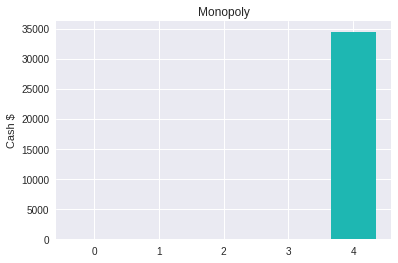

In [41]:
# Declarations
# 5 players, Player 4 is more conservative than others
player_logics = [PLAYER_LOGIC_GREEDY,
                 PLAYER_LOGIC_GREEDY,
                 PLAYER_LOGIC_GREEDY,
                 PLAYER_LOGIC_GREEDY,
                 PLAYER_LOGIC_GREEDY_HAMSTER]
board_file = 'board.csv'

# Get players and board (including properties)
board = get_board(board_file)
players = get_players(player_logics, board)
active_players = len(players)

# Start on round 1
game_round = 1

# Create figure and axis objects
fig, ax = plt.subplots(1, 1)
ax.set_title("Monopoly")
ax.set_ylabel('Cash $')
ind = np.arange(len(player_logics))
colors = ['r', 'g', 'b', '#F58322', '#FFF500', '#8D2C87', '#FCB71E', '#1EB7B2']
random.shuffle(colors)
colors = colors[:len(player_logics)]
bars = None

# Draw barplot
cashes = []
for turn in range(len(player_logics)):
    cash = players[turn].cash
    cashes.append(cash)
bars = ax.bar(ind, cashes, 0.7, color=colors)
fig.canvas.draw()

# Start game
while active_players > 1:

    print("Begin game round: %d with %d active players" % (game_round, active_players))

    # Take turns
    for turn in range(len(player_logics)):
        # End of game -rule: If there is only one player left, there is no point of playing.
        if active_players == 1:
            break

        # Define current player
        curr_player = players[turn]
        if curr_player.bankrupt:
            if VERBOSE:
                print("Player %d is bankrupt, skipping" % turn)
            continue

        # Double roll counter
        n_double_roll = 0

        # Continue turn until player rolls no doubles or goes to jail
        while True:

            # Roll dice
            roll, rolled_double = roll_dice()

            # Update double roll counter
            n_double_roll += (rolled_double).astype(int)

            # If player is in jail
            if players[turn].jail_turns > 0:

                # Select jail strategy
                curr_player.choose_jail_strtg(rolled_double, board)

                # If player is still in jail
                if curr_player.jail_turns > 0:
                    break

            # If player rolled less than 3 doubles
            if n_double_roll < 3:

                # Move player 
                curr_space = curr_player.move(roll, board)

                # No more cash?
                if curr_player.bankrupt:
                    print("Noooooooooo! Player %d went bankrupt." % turn)
                    active_players -= 1
                    curr_player.bankrupt_game_round = game_round
                    curr_player.default(board)
                    break

                prop_type = type(curr_space).__name__
                if prop_type == 'Street' or prop_type == 'Railroad' or prop_type == 'Utility':
                    curr_player.evaluate_buy(curr_space)

                # If no double rolled, end turn
                if not rolled_double:
                    break

            # Otherwise, send player to jail and end turn
            elif n_double_roll == 3:

                curr_player.go_to_jail()
                break

    game_round += 1

    # Update graph data
    cashes = []
    for turn in range(len(player_logics)):
        cash = players[turn].cash
        if players[turn].bankrupt:
            cash = 0
        cashes.append(cash)

    # Draw updated graph
    if bars:
        bars.remove()
        bars = None
    bars = ax.bar(ind, cashes, 0.7, color=colors)
    fig.canvas.draw()

    # Check to see if game is heading towards deadlock
    if board.all_properties_are_owned():
        players_with_monopoly =  board.player_can_build()
        if not players_with_monopoly:
            print("Note: All properties are owned by players. No player can build! This game is likely to end never.")
            if game_round % 10 == 0:
                # Accelerating the game is disabled.
                print("NOTE! No player can build! Accelerating game by doubling rents!")
                for curr_space in board.board:
                    prop_type = type(curr_space).__name__
                    if prop_type == 'Street' or prop_type == 'Railroad' or prop_type == 'Utility':
                        curr_space.rent_now *= 2
                #pass
        else:
            print("Note: All properties are owned by players. Players with monopoly: %s" % players_with_monopoly)

        # Assume, that if game hasn't finished reasonable amount of rounds, there is a bug.
        if game_round == 500:
            print("Game running forever. Stopping.")
            break

# Declare winner
winner = None
for turn in range(len(player_logics)):
    if players[turn].bankrupt:
        continue
    if winner is not None:
        # At least two players not in bankrupt
        winner = None
        break
    winner = turn
if winner is not None:
    print("Player %d wins! Has $%d at the end" % (winner, players[winner].cash))
else:
    print("Nobody won")